# Tutorial for using a Deep Sets model to find open cluster members

**IMPORTANT: this tutorial assumes that the member catalogue, cluster parameters, Gaia credentials and isochrone data have been set up. If this is not the case, follow the steps in the 'Data preparation' sections of the README.md in the same directory as this tutorial.**

This notebook walks through the steps for using a Deep Sets model to find additional open cluster members. It includes the data preparation, training of the model and a demonstration of some results. To decrease the runtime of this tutorial, we only show the steps for a single open cluster, NGC 2423. This is sufficient for instructive purposes, but a general model performs better when trained on multiple clusters.

NGC 2423 is a well-behaved cluster, which allows for a demonstration of the method in favorable conditions. It is also embedded in a relatively small amount of field stars, which decreases the runtime.

First we import some basic packages and then we start with building the required datasets.

In [1]:
import os
import pandas as pd

## Building datasets

The main goal of this section is to build a training dataset for the model to train on. 

### Cluster

The first step is to create a `Cluster` object, which has attributes that relate to the properties of the open cluster. This class is useful for having all relevant cluster properties available in the same location. It requires a dictionary of attributes, which is printed in the next cell.

We need the following properties with corresponding (key):
- name (name)
- position (ra, dec)
- proper motions (pmra, pmdec) + errors (pmra_error, pmdec_error)
- parallax (parallax) + error (parallax_error)
- age (age)
- extinction at 550 nm (a0)
- distance (dist)

We can take extract these properties automatically from the downloaded cluster data by using the `load_cluster_parameters` function.

Note: Although the distance can be calculated with the parallax, we use explicit distances obtained by Cantat-Gaudin et al. (2020). These were determined by a neural network that also took the distribution of the members in the colour-magnitude diagram (CMD) into account. The CMD distribution constrains the distance modulus and thus the distance, which is helpful as the parallax often has relatively large errors and is subject to systematic biases.

In [2]:
from gaia_oc_amd.io import load_cluster_parameters
from gaia_oc_amd.data_preparation.cluster import Cluster

# The file cluster_parameters.tsv contains cluster properties from Cantat-Gaudin et al. (2020)
cluster_path = 'data/cluster_parameters.csv'
cluster_name = 'NGC_2423'

cluster_params = load_cluster_parameters(cluster_path, cluster_name)

print(cluster_params)

cluster = Cluster(cluster_params)

{'name': 'NGC_2423', 'ra': 114.299, 'dec': -13.863, 'pmra': -0.735, 'pmdec': -3.632, 'pmra_error': 0.124, 'pmdec_error': 0.149, 'parallax': 1.045, 'parallax_error': 0.051, 'age': 9.04, 'a0': 0.36, 'dist': 943.0}


### Cone search

Now that we have cluster properties, we can download sources from the Gaia archive that have similar properties and which therefore might be members of the cluster. We also want to include some informative non-members, such that the model can be trained with both positive and negative examples of open cluster members. 

The `cone_search` function uses the `astroquery` package to download sources from the Gaia archive by performing a cone search on the cluster. For a source to be included, it must satisfy 3 conditions:
- Its sky position must be within a projected radius of 60 parsec from the cluster mean
- Its proper motion must be within 10 sigma of the cluster mean
- Its parallax must be within 10 sigma of the cluster mean

These conditions ensure the inclusion of both candidates and (informative) non-members.

The `cone_search` function makes a `clusters_dir` folder if it does not exist yet and creates a subfolder with the same name as that of the `Cluster` object, which is the first argument provided to `cone_search`. In the cluster-specific subfolder, we save a 'cone.vot.gz' file which contains the cone sources in votable format.

In [3]:
from gaia_oc_amd.data_preparation.query import cone_search

# The gaia_credentials file contains the username and password to log into the Gaia archive 
credentials_path = 'data/gaia_credentials'
clusters_dir = 'tutorial_clusters'

cluster_dir = os.path.join(clusters_dir, cluster.name)
cone_path = os.path.join(cluster_dir, 'cone.vot.gz')
if not os.path.exists(cone_path):
    cone_search(cluster, clusters_dir, credentials_path)

We load the cone sources as a `pandas` dataframe with the `load_cone` function. Next we use the `cone_preprocessing` function to apply the following pre-processing steps:
- Remove sources from the cone with no BP-RP colour.
- Subtract the parralax zero-point from the parallax of each source based on the recipe from Lindegren et al. (2021).
- Correct the colour and magitude of the sources based on the cluster's extinction coefficient `a0`.
- Shift the sky position of some sources by a period if the cluster is located too close to a coordinate max value (such that sources for example don't have both l $\approx$ 0 and l $\approx$ 360, which results in bad plots).
- Add columns containing the uncertainties for the G magnitude and BP-RP colour, which are derived from the errors in the flux.
- Give each source a default membership probability (PMemb) of 0%.

In [4]:
from gaia_oc_amd.io import load_cone
from gaia_oc_amd.data_preparation.cone_preprocessing import cone_preprocessing

cone = load_cone(cone_path)
cone = cone_preprocessing(cone, cluster.a0)

print(cone.head())

           ra        dec  parallax      pmra     pmdec  parallax_error  \
0  114.910344 -16.704103  0.817917 -0.414906 -3.625576        0.443619   
1  115.000699 -16.685701  0.880663 -0.054926 -2.542712        0.042634   
2  114.532877 -16.890875  1.244049 -1.034738 -4.418937        0.183606   
3  114.437877 -16.891899  0.706049  0.067607 -2.935933        0.054689   
4  114.440443 -16.829174  0.734700  0.155468 -3.151061        0.077532   

   pmra_error  pmdec_error  parallax_pmra_corr  parallax_pmdec_corr  ...  \
0    0.467061     0.448325            0.163529            -0.058578  ...   
1    0.040779     0.042695            0.218927            -0.134688  ...   
2    0.141685     0.167208            0.168062            -0.230123  ...   
3    0.047232     0.051495            0.201984            -0.244891  ...   
4    0.069689     0.072562            0.267390            -0.198624  ...   

      bp_rp           l         b  nu_eff_used_in_astrometry  pseudocolour  \
0  1.939464  233.258

Now that we have preprocessed cone source data, we want to label each source as either a candidate member of the cluster or a non-member. To do this, we use a set of probable members of the cluster and its theoretical isochrone.

### Train members

To use this method to find open cluster members, we require a set of already established members. We use these members to determine which cone sources we label as candidates and to train the model to identify additional members. We can use the membership lists from Cantat-Gaudin et al. (2020), which were obtained with a clustering algorithm. The file at `members_path` contains the source identities and corresponding membership probabilities of open cluster members.

In [5]:
from gaia_oc_amd.io import load_members

members_path = 'data/cg20_members.csv'
members = load_members(members_path, cluster.name)

print(members.head())
print('Total train members:', len(members))
print('Mean member probability:', members['PMemb'].mean())

             source_id  PMemb
0  3030442582338182016    0.1
1  3030412620646875264    0.6
2  3030382040479470592    0.9
3  3030418633601087872    0.5
4  3030435744750529920    0.6
Total train members: 511
Mean member probability: 0.8205479452054795


As we want to train our model on sources that are very likely to be members, we determine the source identities of sources that have a 100% probability of being a member. This leaves us with 263 highly probable members.

In [6]:
prob_threshold = 1.0
hp_members = members[members['PMemb'] >= prob_threshold]

print('High probability train members:', len(hp_members))

High probability train members: 263


Next we use the `member_set` function to crossmatch these identities with our cone search sources to obtain a set of train members. Note that we now have the high precision astrometric and photometric measurements from the Gaia EDR3 cone search for these members. 

In [7]:
from gaia_oc_amd.data_preparation.source_sets import member_set

# Construct the member set
train_members = member_set(cone, hp_members['source_id'], hp_members['PMemb'])

print(train_members.head())

             source_id  PMemb          ra        dec  parallax      pmra  \
0  3030436500664697856    1.0  114.862311 -13.951458  1.031423 -0.785990   
1  3030449110688081792    1.0  114.757871 -13.922463  1.135603 -0.835132   
2  3030451825107906944    1.0  114.870703 -13.811820  1.091752 -0.795960   
3  3030443132093961216    1.0  115.225010 -13.800658  1.141499 -0.855718   
4  3030447770658933376    1.0  114.797960 -13.981981  1.016568 -0.827355   

      pmdec  parallax_error  pmra_error  pmdec_error  ...  phot_g_mean_mag  \
0 -3.634597        0.042552    0.035973     0.035705  ...        15.656757   
1 -3.627954        0.026783    0.024053     0.021041  ...        14.681610   
2 -3.625965        0.022774    0.020985     0.018956  ...        14.396268   
3 -3.609161        0.023897    0.022792     0.019656  ...        14.705857   
4 -3.618987        0.021343    0.016768     0.016815  ...        13.343094   

      bp_rp           l         b  nu_eff_used_in_astrometry  pseudocolour

Before moving on, let's take a look at the distribution of these members with the `plot_sources` function. This function makes four plots to show the distribution of sources in sky position, proper motion, parallax and the CMD. As will be shown later, the `plot_sources` function has a number of options, such as adding field stars to the plots or adding a second member set for comparison.

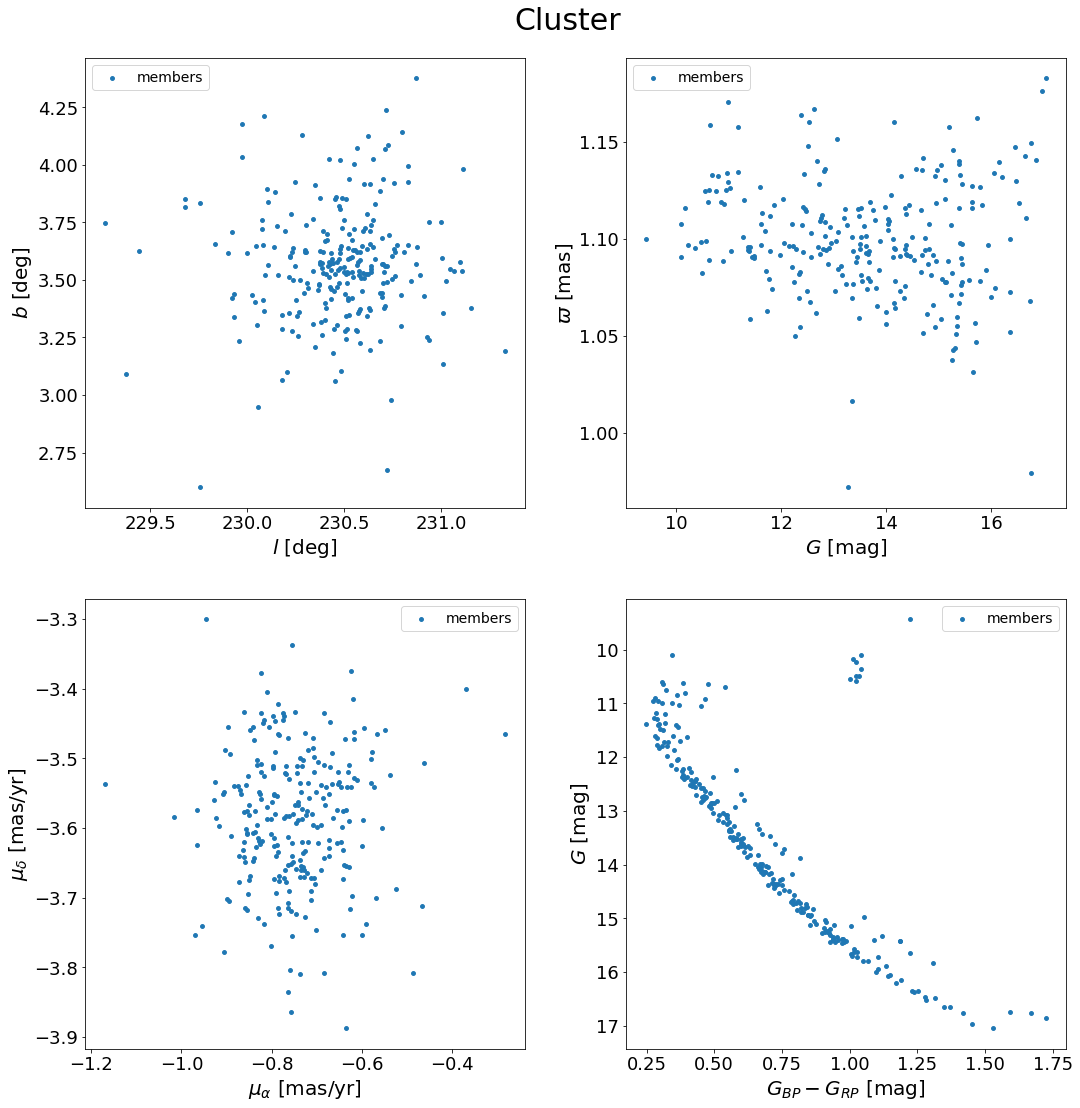

In [8]:
from gaia_oc_amd.candidate_evaluation.visualization import plot_sources

plot_sources(train_members)

### Isochrone

Next, we load the isochrone corresponding to the age and distance of the cluster (we assume a default metal fraction of $Z=0.0152$). The `load_isochrone` function includes the following steps to produce a dataframe with isochrone data.
- It uses the cluster age to retrieve the correct isochrone from the 'isochrones.dat' file
- It corrects the isochrone magnitudes with the distance modulus
- It excludes data for stars beyond a given evolutionary stage (early asymptotic giant branch by default)

In [9]:
from gaia_oc_amd.io import load_isochrone

print('Cluster log(age):', cluster.age)
print('Cluster distance:', cluster.dist)

isochrone_path = 'data/isochrones.dat'
isochrone = load_isochrone(isochrone_path, cluster.age, cluster.dist)

print('Number of data points:', len(isochrone))
print(isochrone.head())

Cluster log(age): 9.04
Cluster distance: 943.0
Number of data points: 270
   bp_rp  phot_g_mean_mag
0  4.409        25.171558
1  4.399        24.761558
2  4.370        24.243558
3  4.261        24.059558
4  3.868        23.407558


### Labeling cone sources

With the train members and isochrone, we can now label the cone sources as either candidate or non-member. This is done by giving the `Cluster` object all the necessary information relating to the candidate selection, which is then passed to the `candidate_and_non_members_set` to separate the cone sources.

First we update the astrometric parameters of the cluster based on our training members. This is not strictly necessary, but updating the parameters ensures that the non members and candidates conform to our member distribution. 

Second, we provide the parameters used by the candidate selection algorithm. The `set_candidate_selection_parameters` function requires the training members, the isochrone data and a number of keyword arguments that essentially tune the 'strictness' of the candidate selection in certain dimensions. 

In order for sources to be selected as candidates, they need to satisfy three conditions, relating to their proper motion, parallax, G magnitude and BP-RP colour. In words, sources that do not deviate significantly from (i) the mean cluster proper motion, (ii) the mean cluster parallax and (iii) the isochrone are selected as candidate. For a detailed explanation of the candidate selection algorithm we refer to our paper.

In [10]:
from gaia_oc_amd.data_preparation.source_sets import candidate_and_non_member_set

# Update the cluster parameters based on the members
cluster.update_astrometric_parameters(train_members)

# Set cluster parameters that are relevant for the candidate selection and training features
cluster.set_candidate_selection_parameters(train_members, isochrone, source_error_weight=3., pm_error_weight=3.,
                                           r_max_margin=15., zpt_error=0.015, delta_c0=0.5, delta_g0=1.5, 
                                           c_margin=0.25, g_margin=0.75, member_fraction=0.90, alpha=0.95)

# Construct the candidate and non-member set
candidates, non_members = candidate_and_non_member_set(cone, cluster)

print('Members:', len(members))
print('Candidates:', len(candidates))
print('Non members:', len(non_members))

Members: 511
Candidates: 3905
Non members: 5982


Below, we plot the distribution of the members, candidates and non-members with the `plot_sources` function. 

The main components of the candidate selection are the 'maximum separation delta' which determine the boundaries between candidates and non-members for sources with negligible errors. These are visualized by the red dashed lines in the plot below. Sources that are further than 3 standard deviations outside these boundaries are not selected as candidate. 

For showing the boundaries, as well as the isochrone, the `plot_sources` function needs to be supplied with a `Cluster` object for which the candidate selection parameters have been set.

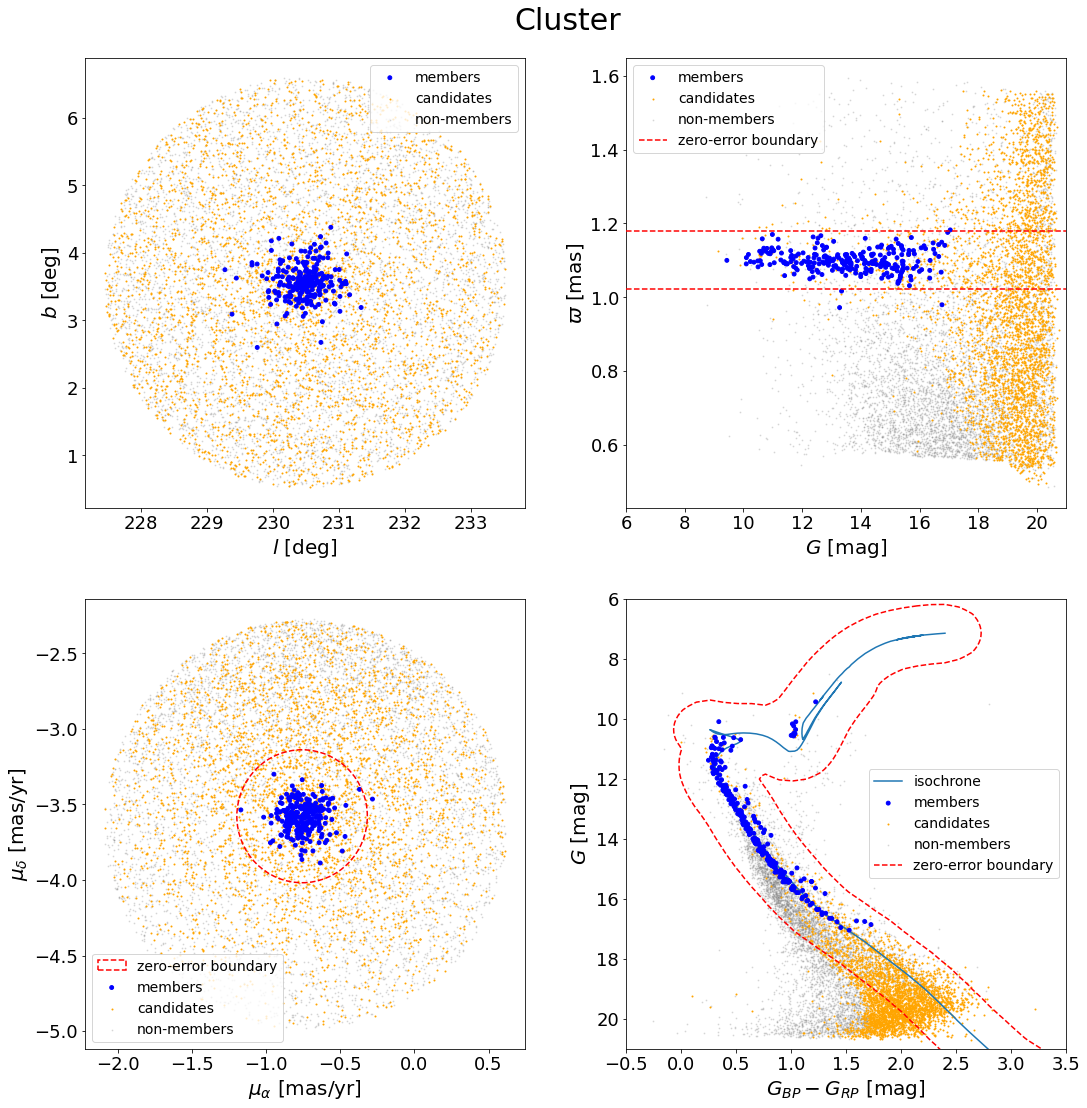

In [11]:
limits = {'phot_g_mean_mag': [6, 21], 'bp_rp': [-0.5, 3.5]}

plot_sources(train_members, candidates=candidates, field_sources=non_members, plot_type='candidates',
             cluster=cluster, show_boundaries=True, show_isochrone=True, limits=limits)

### Features

To teach the model to differentiate members from non-members, we supply all sources with with a number of features that relate to their likelihood of being a member. The feature functions expect a row from a sources dataframe as input and outputs the feature value. We use the `add_columns` function to apply the feature functions to multiple dataframes.

The five features are:
- `f_r`, separation from the cluster mean in sky position
- `f_pm`, separation from the cluster mean in proper motion
- `f_plx`, separation from the cluster mean in parallax
- `f_c`, colour component of the separation from the isochrone
- `f_g`, G magnitude component of the separation from the isochrone

All but the `f_r` feature are scaled by the maximum separation delta such that feature=1 for a source located on the corresponding zero-error boundary (for the CMD it's sqrt(f_c^2 + f_g^2)=1).

In [12]:
from gaia_oc_amd.data_preparation.features import add_features

add_features([train_members, candidates, non_members], cluster)

print(train_members[['f_r', 'f_pm', 'f_plx', 'f_c', 'f_g']][:5])

         f_r      f_pm     f_plx       f_c       f_g
0   9.200251  0.143691  0.876317  0.151141 -0.025288
1   7.473333  0.210594  0.446364  0.141902  0.019952
2   9.184702  0.139838  0.104759  0.045358 -0.151732
3  14.848615  0.235463  0.520169  0.105745  0.007731
4   8.314826  0.184927  1.066291 -0.207821  0.136418


 We can visualize the features of a candidate with the `show_features` keyword.

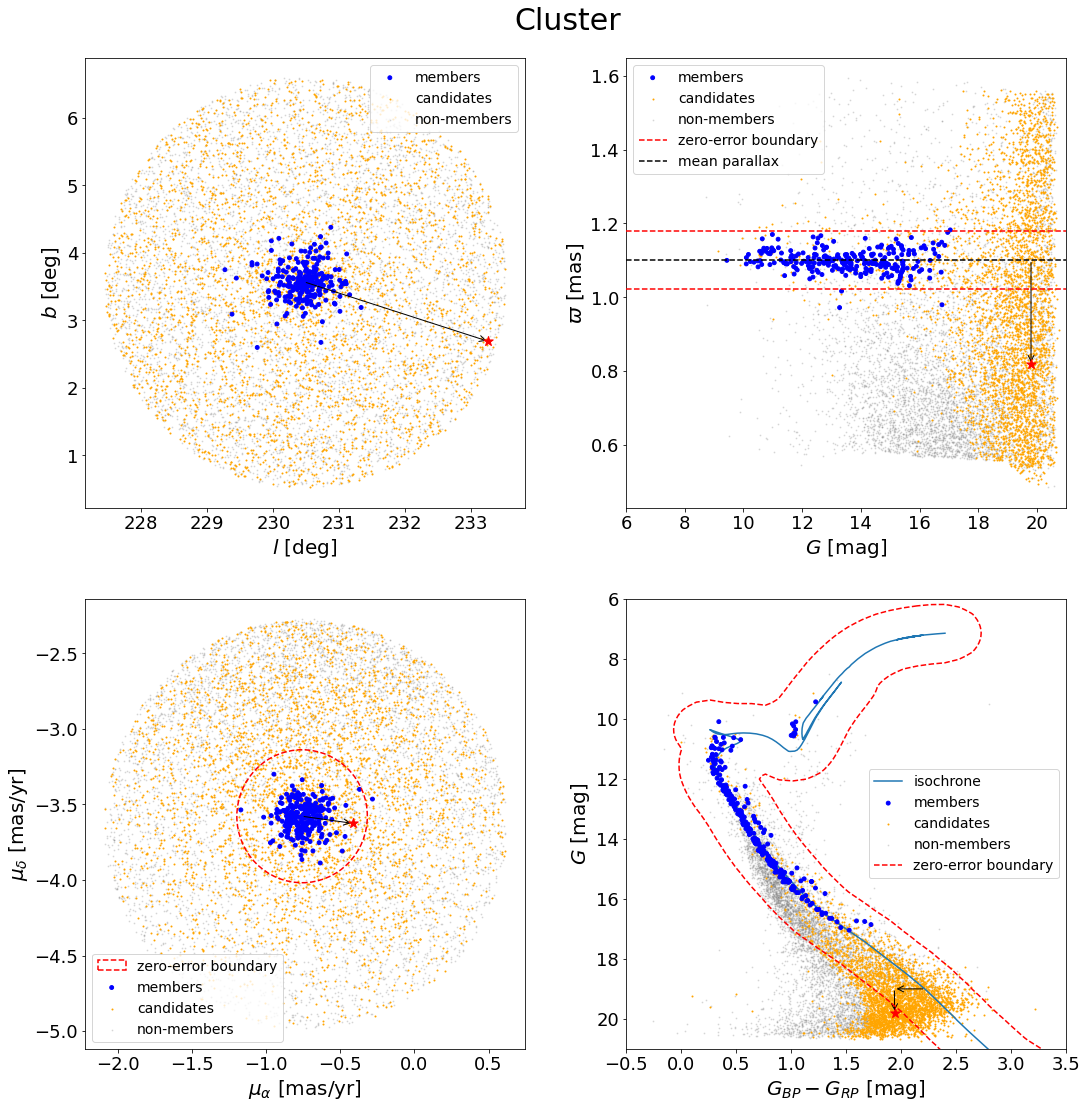

In [13]:
plot_sources(train_members, candidates=candidates, field_sources=non_members, plot_type='candidates',
             cluster=cluster, show_features_source_id=candidates['source_id'].values[0], 
             show_boundaries=True, show_isochrone=True, limits=limits)

### Saving and loading data

To store the cluster object and the various sets, we can use the `save_cluster` and `save_sets` functions. To load them, use the `load_cluster` and `load_sets` function.

In [14]:
from gaia_oc_amd.io import save_sets, save_cluster

save_cluster(cluster_dir, cluster)
save_sets(cluster_dir, train_members, candidates, non_members)

# from gaia_oc_amd.io import load_sets, load_cluster
#
# cluster = load_cluster(cluster_dir)
# train_members, candidates, non_members, _ = load_sets(cluster_dir)

### Creating a training dataset

With the members and non-members, we create training instances with the `multi_cluster_deep_sets_dataset` function. This function uses a list of cluster names to load the members, non-members and candidates from respective csv files in `clusters_dir\cluster_name`, which are saved there by `save_sets`. Each instance in the training set consist of a tuple containing the model input and a label. 

The model input is made up of a source we want to classify (either a member or a non-member) and a support set (a random set of members). The model is essentially trained to recognize when the source-to-classify is similar enough to the positive examples in the support set, i.e. to members. 

In `multi_cluster_deep_sets_dataset` the features are first standardized, i.e we subtract the mean and divide by the standard deviation. We calculate the means and standard deviations outside the function so we do not need to calculate them again when we create a dataset for the candidates. The values of `n_pos_duplicates` and `neg_pos_ratio` determine, respectively, how many times each member is used as a source-to-classify and how many non-members (of the same cluster) should be included for every member. Since we only have 257 members and 7326 non-members, we only include 257 * 2 * 5 / 7326 * 100 = 35% of the non-members in our dataset with these settings. The `n_min_members` keyword makes sure that only clusters with more than a certain number of members are included in the dataset. This value must also be larger than the size of the support set.

In [15]:
from gaia_oc_amd.data_preparation.datasets import multi_cluster_deep_sets_dataset
from gaia_oc_amd.utils import property_mean_and_std

# data params
cluster_names = [cluster_name]
n_pos_duplicates = 2
neg_pos_ratio = 5
size_support_set = 10
n_min_members = 15
training_features = ['f_r', 'f_pm', 'f_plx', 'f_c', 'f_g']

training_feature_means, training_feature_stds = property_mean_and_std(clusters_dir, cluster_names,
                                                                      training_features)
train_dataset = multi_cluster_deep_sets_dataset(clusters_dir, cluster_names, training_features,
                                                training_feature_means, training_feature_stds,
                                                n_pos_duplicates=n_pos_duplicates, 
                                                neg_pos_ratio=neg_pos_ratio, 
                                                size_support_set=size_support_set, 
                                                n_min_members=n_min_members)

Creating cluster(s) dataset: 100%|██████████████████████████████████| 1/1 [00:00<00:00,  9.45it/s]


The `DeepSetsDataset` is a child class of PyTorch's `Dataset` class, which can be supplied to the `DataLoader` to create a batched dataset, which is shuffled before every epoch.

The shape of the model input is a [batch $\times$ size_support_set $\times$ $2M$] tensor, where $M$ the number of features used for training. The factor 2 is there because the features of the source-to-classify are concatenated to the features of each support set source.

The label of each dataset instance indicates the class of the source-to-classify, with [0, 1] for member and [1, 0] for non-member.

In [16]:
from gaia_oc_amd.data_preparation.datasets import DeepSetsDataset
from torch.utils.data import DataLoader

batch_size = 32

train_dataset = DataLoader(DeepSetsDataset(train_dataset), batch_size=batch_size, shuffle=True)

model_input, label = next(iter(train_dataset))

print('Input shape:', model_input.shape)
print('Model input:', model_input[0])
print('Label:', label[0])

Input shape: torch.Size([32, 10, 10])
Model input: tensor([[ 0.1403, -0.0467, -0.5203,  0.8558, -0.7580, -2.1340, -2.0265, -1.5194,
         -0.7736,  0.7373],
        [ 0.1403, -0.0467, -0.5203,  0.8558, -0.7580, -2.2781, -2.1404, -1.5371,
         -0.7696,  1.0639],
        [ 0.1403, -0.0467, -0.5203,  0.8558, -0.7580, -1.7689, -2.2419, -1.2746,
         -0.8001,  0.7511],
        [ 0.1403, -0.0467, -0.5203,  0.8558, -0.7580, -1.6001, -1.9195, -1.6274,
         -0.7436,  0.8666],
        [ 0.1403, -0.0467, -0.5203,  0.8558, -0.7580, -2.1986, -2.1801, -1.4611,
         -0.7263,  0.7508],
        [ 0.1403, -0.0467, -0.5203,  0.8558, -0.7580, -2.2533, -2.1215, -1.6803,
         -0.7652,  0.7803],
        [ 0.1403, -0.0467, -0.5203,  0.8558, -0.7580, -1.8722, -2.2199, -1.7317,
         -0.8461,  0.8110],
        [ 0.1403, -0.0467, -0.5203,  0.8558, -0.7580, -1.7756, -2.1867, -1.5180,
         -0.6549,  0.8412],
        [ 0.1403, -0.0467, -0.5203,  0.8558, -0.7580, -1.7773, -1.8060, -1.52

## Training the model

Now that we have the datasets, we can train the model. We start by instantiating a Deep Sets model, developed by Zaheer et al. (2017), where the 5 in `D5` indicates the number of permutation equivariant layers in the model, for which 5 was used by Oladosu et al. (2021).

We use 64 hidden units and a 'mean' pooling function. The `x_dim` is determined by the number of features and `out_dim` represents the number of classes (member and non-member).

In [17]:
from gaia_oc_amd.machine_learning.deepsets_zaheer import D5

# model params
hidden_size = 64

model = D5(hidden_size, x_dim=2 * len(training_features), pool='mean', out_dim=2)

Training is done with the `train_model` function, where we train here for a maximum of 20 epochs, use a learning rate `lr` of $10^{-5}$ and an l2 regularization weight `l2` of $10^{-5}$ as well. The `weight_imbalance`, used to mitigate an imbalanced dataset, is the factor by which the loss is multiplied when classifying members. A higher value thus increases the penalty for failing to classify members, but can bias the model to select some non-members as members as well. During training, we keep track of the F1 score to estimate the performance. The model parameters are saved in the directory given by `model_save_dir`. A validation set can also be created in the same way as the training set and provided to `train_model`.

In [18]:
from gaia_oc_amd.machine_learning.training import train_model
from torch import load

model_dir = os.path.join(os.getcwd(), 'tutorial_model')

# training params
n_epochs = 20
lr = 1e-5
l2 = 1e-5
weight_imbalance = 5.

metrics = train_model(model, model_dir, train_dataset, val_dataset=None, 
                      num_epochs=n_epochs, lr=lr, l2=l2, weight_imbalance=weight_imbalance)

train epoch 0: 100%|████████████████████████| 97/97 [00:00<00:00, 275.66it/s, loss=34.1, f1=31.7%]


train epoch 1: 100%|████████████████████████| 97/97 [00:00<00:00, 283.73it/s, loss=29.6, f1=44.7%]


train epoch 2: 100%|████████████████████████| 97/97 [00:00<00:00, 269.83it/s, loss=24.4, f1=67.4%]


train epoch 3: 100%|████████████████████████| 97/97 [00:00<00:00, 277.86it/s, loss=19.2, f1=83.1%]


train epoch 4: 100%|████████████████████████| 97/97 [00:00<00:00, 269.15it/s, loss=14.1, f1=91.0%]


train epoch 5: 100%|██████████████████████████| 97/97 [00:00<00:00, 275.22it/s, loss=10, f1=94.0%]


train epoch 6: 100%|████████████████████████| 97/97 [00:00<00:00, 302.52it/s, loss=6.79, f1=95.8%]


train epoch 7: 100%|█████████████████████████| 97/97 [00:00<00:00, 306.06it/s, loss=4.4, f1=96.9%]


train epoch 8: 100%|████████████████████████| 97/97 [00:00<00:00, 313.37it/s, loss=2.99, f1=97.5%]


train epoch 9: 100%|████████████████████████| 97/97 [00:00<00:00, 280.78it/s, loss=1.86, f1=97.9%]


train epoch 10: 100%|████████████████████████| 97/97 [00:00<00:00, 311.93it/s, loss=1.3, f1=98.1%]


train epoch 11: 100%|██████████████████████| 97/97 [00:00<00:00, 309.73it/s, loss=0.912, f1=98.5%]


train epoch 12: 100%|██████████████████████| 97/97 [00:00<00:00, 308.71it/s, loss=0.736, f1=98.7%]


train epoch 13: 100%|██████████████████████| 97/97 [00:00<00:00, 313.44it/s, loss=0.565, f1=99.2%]


train epoch 14: 100%|███████████████████████| 97/97 [00:00<00:00, 313.03it/s, loss=0.45, f1=99.2%]


train epoch 15: 100%|███████████████████████| 97/97 [00:00<00:00, 298.65it/s, loss=0.43, f1=99.3%]


train epoch 16: 100%|██████████████████████| 97/97 [00:00<00:00, 305.34it/s, loss=0.362, f1=99.3%]


train epoch 17: 100%|██████████████████████| 97/97 [00:00<00:00, 278.60it/s, loss=0.267, f1=99.5%]


train epoch 18: 100%|██████████████████████| 97/97 [00:00<00:00, 305.06it/s, loss=0.263, f1=99.3%]


train epoch 19: 100%|██████████████████████| 97/97 [00:00<00:00, 289.92it/s, loss=0.233, f1=99.5%]


We can visualize the training process by plotting the evolution of the loss value and a number of metrics. At the end of training, the members and non-members are classified with near perfect accuracy.

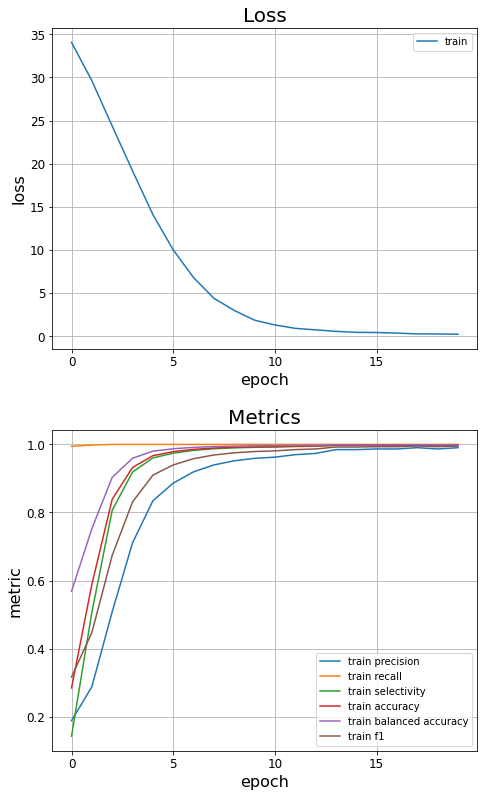

In [19]:
from gaia_oc_amd.candidate_evaluation.visualization import plot_metrics

plot_metrics(metrics, model_dir)

### Evaluating candidates

Once the model is trained, we can use it to evaluate the candidates.

To take the errors in the astrometric and photometric properties of the candidates into account, we resample the training features of each candidate a number of times, based on the uncertainties and correlations of its properties. The smaller the errors of the candidate properties, the more compact the sample distribution will be and the more similar the membership predictions for the samples of that candidate. We interpret the fraction of samples that were identified by the model as member as the candidate's membership probability. Here, 'identified as member' means that the model outputs a softmax probability of greater than 50% for the member class.

The `calculate_probabilities` function first generates the candidate samples and then creates a deep sets dataset for each sample. The training features also need to be re-calculated, as the properties on which they depend have different values. The training features are normalized for the deep sets dataset and thus we require the feauture means and standard deviations as well. Each candidate is also given a new support set for each sample. From the sample predictions (i.e. member=True/False), the membership probabilities are calculated.

We give the probabilities to the candidate set in the `Sources` class, so that they can be used for plots. We also overwrite the csv file where the candidates were stored to now include the probabilites as well.

Depending on the number of candidates and samples, this evaluation process may take only a few seconds or up to an hour for $\sim$$10^{5}$ candidates. 

In [20]:
import torch
from gaia_oc_amd.candidate_evaluation.membership_probability import calculate_probabilities

model.load_state_dict(torch.load(os.path.join(model_dir, 'model_parameters')))

# evaluation params
n_samples = 100

candidates['PMemb'] = calculate_probabilities(candidates, model, cluster, train_members,
                                              training_features, training_feature_means,
                                              training_feature_stds, size_support_set=size_support_set,
                                              n_samples=n_samples)
candidates.to_csv(os.path.join(cluster_dir, 'candidates.csv'))

Evaluating candidate samples: 100%|█████████████████████████████| 100/100 [01:27<00:00,  1.15it/s]


## Results

With the membership probabilities of the candidates determined, we can check their distribution and see how they compare against another member set.

We can plot the evaluated candidates above a certain probability with the `plot_sources` function. We take the subset of members with a membership probability of 80% or higher and treat the other candidates to the non-members.

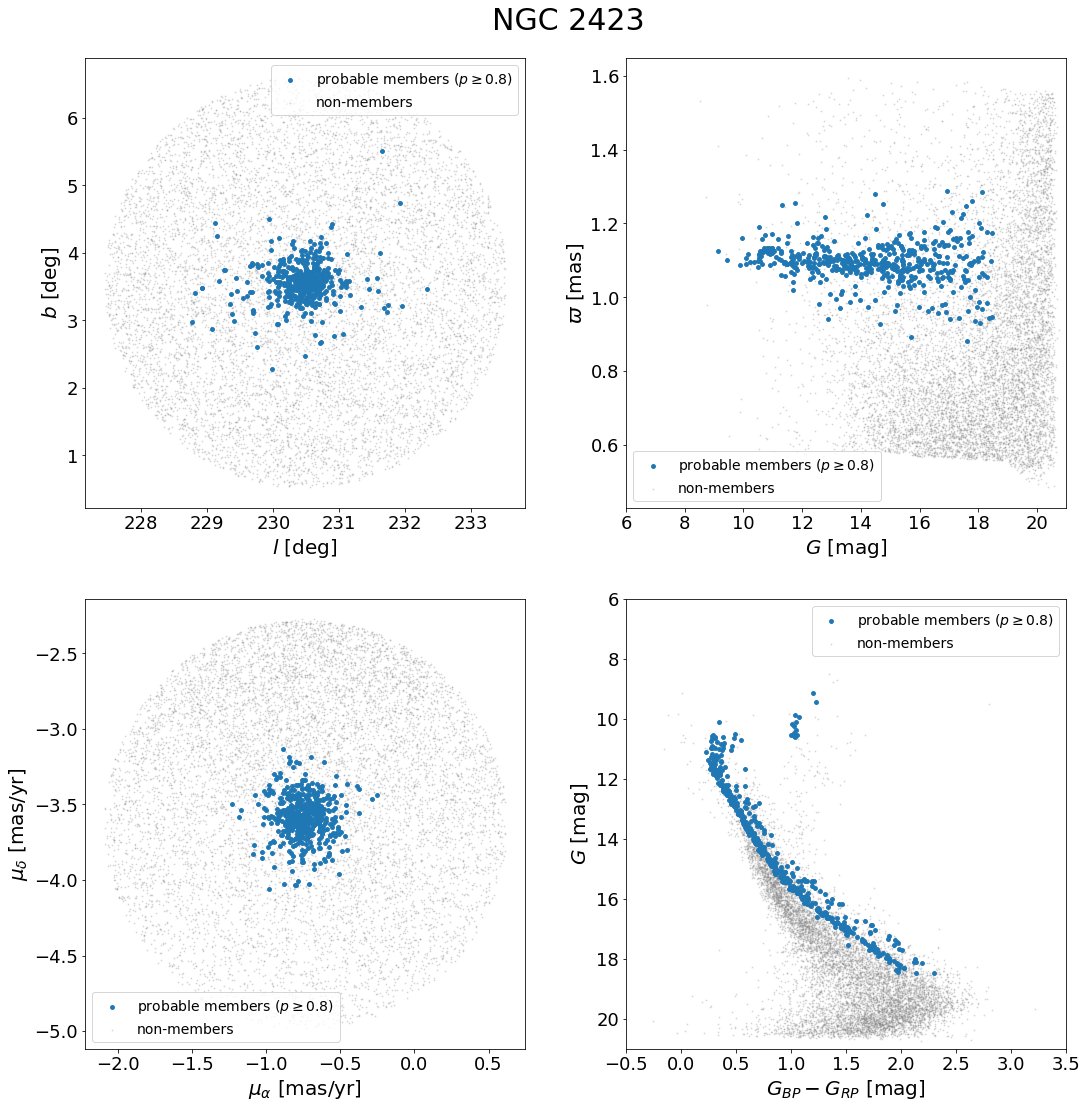

In [21]:
prob_threshold = 0.8
member_candidates = candidates[candidates['PMemb'] >= prob_threshold]
non_member_candidates = pd.concat((non_members, candidates[candidates['PMemb'] < prob_threshold]))

plot_title = f'{cluster.name}'.replace('_', ' ')

plot_sources(member_candidates, field_sources=non_member_candidates,
             members_label=f'probable members ($p\\geq${prob_threshold})', 
             title=plot_title, limits=limits)

### Compare members

If available, we can also define some 'comparison' members, which we can use to compare against the members obtained by the DS model. Here we use membership lists from Tarricq et al. (2022).

In [22]:
comparison_members_path = 'data/t22_members.csv'
comparison_members = load_members(comparison_members_path, cluster.name)

comparison_member_ids = comparison_members['source_id']
comparison_member_probs = comparison_members['PMemb']

comparison_members = member_set(cone, comparison_member_ids, comparison_member_probs)

print('Total comparison members:', len(comparison_members))
print('Mean comparison member probability:', comparison_member_probs.mean())

Total comparison members: 506
Mean comparison member probability: 0.7976712328767124


We can compare the member sets in a number of different ways, including:

- A density profile, which shows how well a King model fits the projected density distribution of candidates with a membership probability of 10% or higher (this plot works better if the model is not trained on the sky position radius `f_r`).
- A mass segregation profile, which shows the degree to which the distribution of the $N_{MST}$ most massive members is more clustered than a distribution of $N_{MST}$ random members. The tightness of the clustering is measured with the length of the minimum spanning tree, which connects the members in projected sky position coordinates. A value higher than 1 means that the $N_{MST}$ most massive members are more tightly clustered.
- A venn diagram, showing the overlap between the different member sets for members above a 10%, 50% and 90% probability threshold. Red are comparison members not found by our method, green are members we obtain which are not in the comparison set and light brown is the overlap.
- A 'confusion matrix', which shows how boths sets compare in the probabilities they ascribe to the candidates. Sources that only occur in one set are given a default membership probability of 0% in the other set.
- A `plot_sources` with `plot_type='comparison'`, with the comparison members and the candidates with probabilities above 10%. Darker colours indicate a higher membership probability. Note that sources with a $G$ magnitude fainter than 18 were not included in the analysis that produced the comparison membership list. 
- A `plot_sources` with `plot_type='unique_members'`, where we show the members found by the DS model which are not in the comparison set. The membership probability is colour-coded.
- The reverse of the previous plot, where we show the members that are only in the comparison member set.

In [23]:
from gaia_oc_amd.candidate_evaluation.visualization import plot_density_profile, plot_mass_segregation_profile, plot_venn_diagram, plot_confusion_matrix

prob_threshold = 0.1
member_candidates = candidates[candidates['PMemb'] >= prob_threshold]
non_member_candidates = pd.concat((non_members, candidates[candidates['PMemb'] < prob_threshold]))
comparison_members = comparison_members[comparison_members['PMemb'] >= prob_threshold]

members_label = 'tutorial members'
comparison_label = 'comparison members'

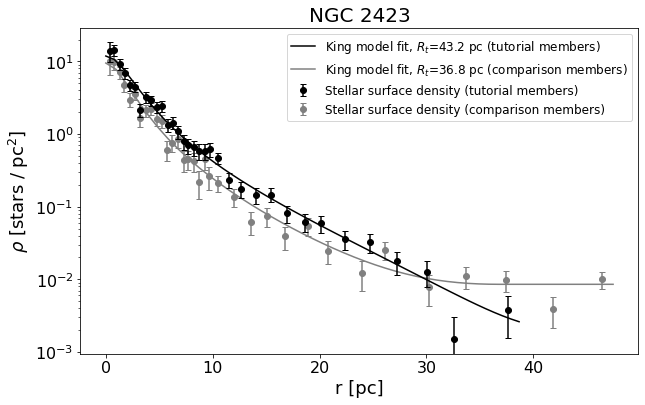

In [24]:
plot_density_profile(member_candidates, cluster, comparison_members,
                     members_label=members_label, comparison_label=comparison_label,
                     title=plot_title)

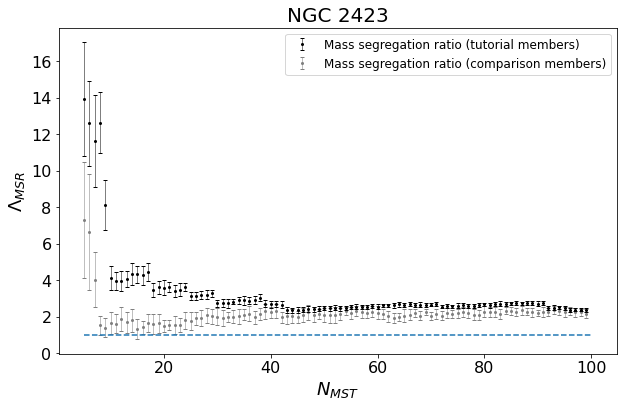

In [25]:
plot_mass_segregation_profile(candidates, cluster, comparison_members,
                              members_label=members_label, comparison_label=comparison_label,
                              title=plot_title)

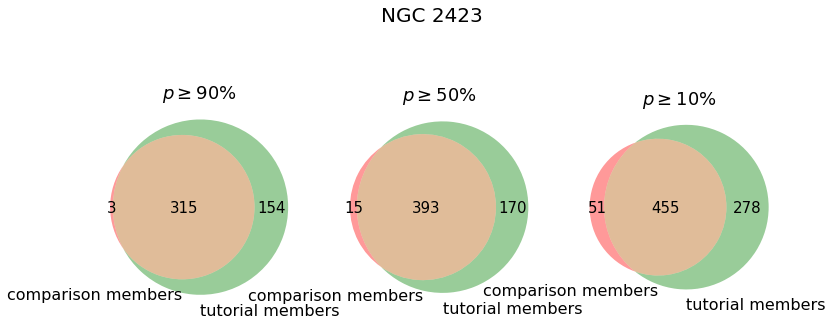

In [26]:
plot_venn_diagram(member_candidates, comparison_members, title=plot_title, 
                  label1=members_label, label2=comparison_label)

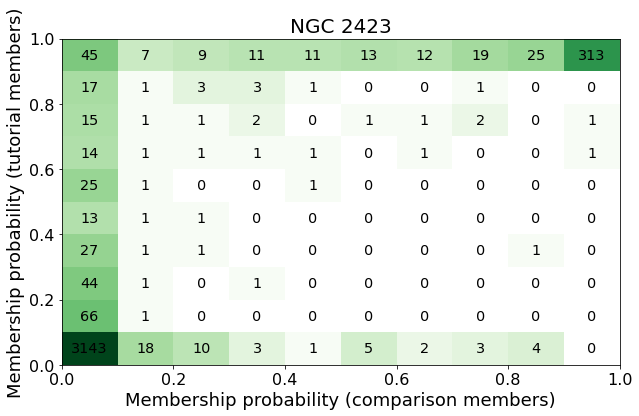

In [27]:
plot_confusion_matrix(candidates, comparison_members, title=plot_title, 
                      label1=members_label, label2=comparison_label)

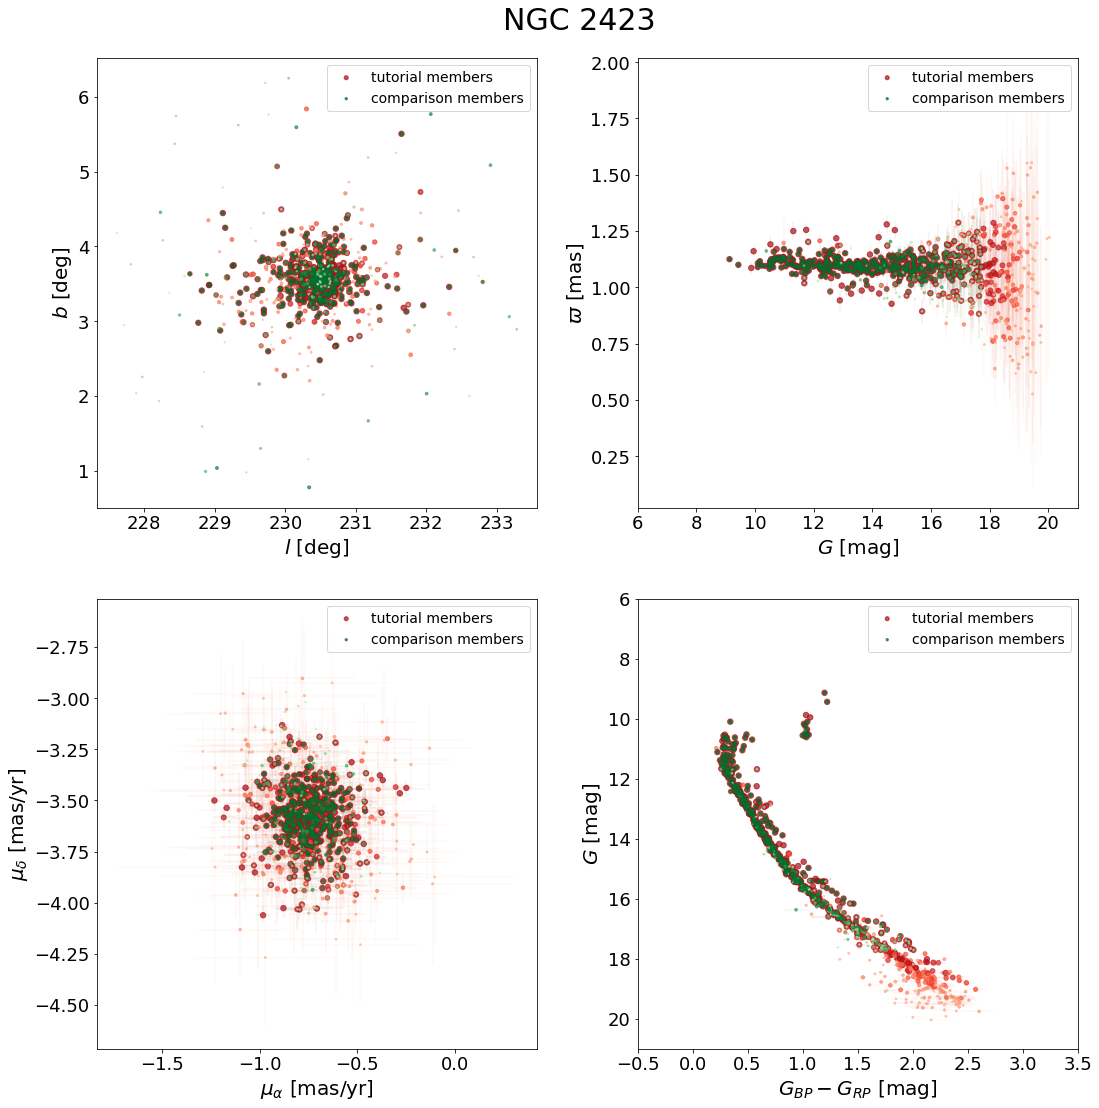

In [28]:
plot_sources(member_candidates, comparison=comparison_members, 
             plot_type='comparison', members_label=members_label,
             comparison_label=comparison_label, title=plot_title, limits=limits)

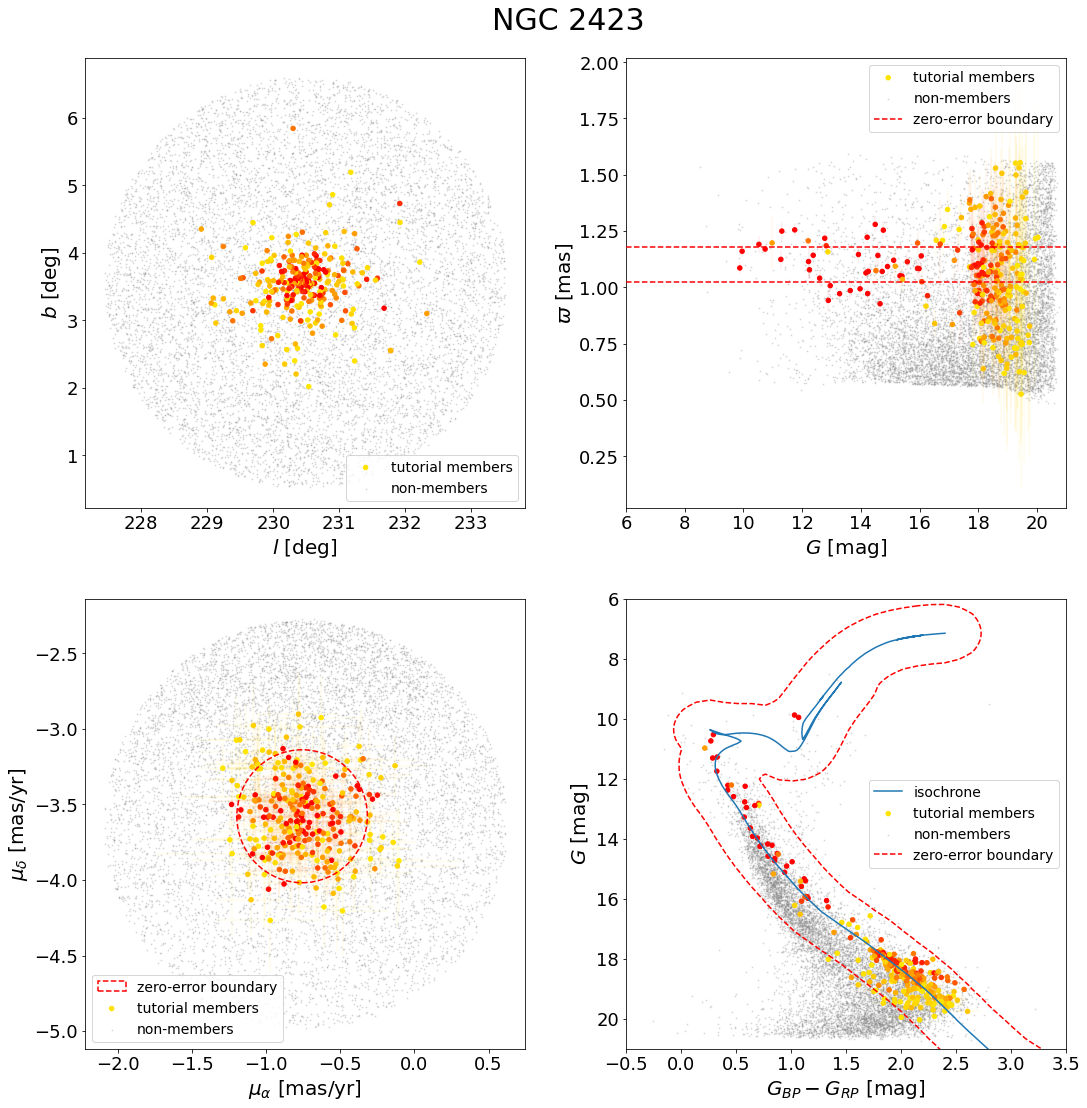

In [29]:
plot_sources(member_candidates, comparison=comparison_members, field_sources=non_member_candidates, 
             plot_type='unique_members', members_label=members_label, title=plot_title, 
             limits=limits, show_isochrone=True, show_boundaries=True, cluster=cluster)

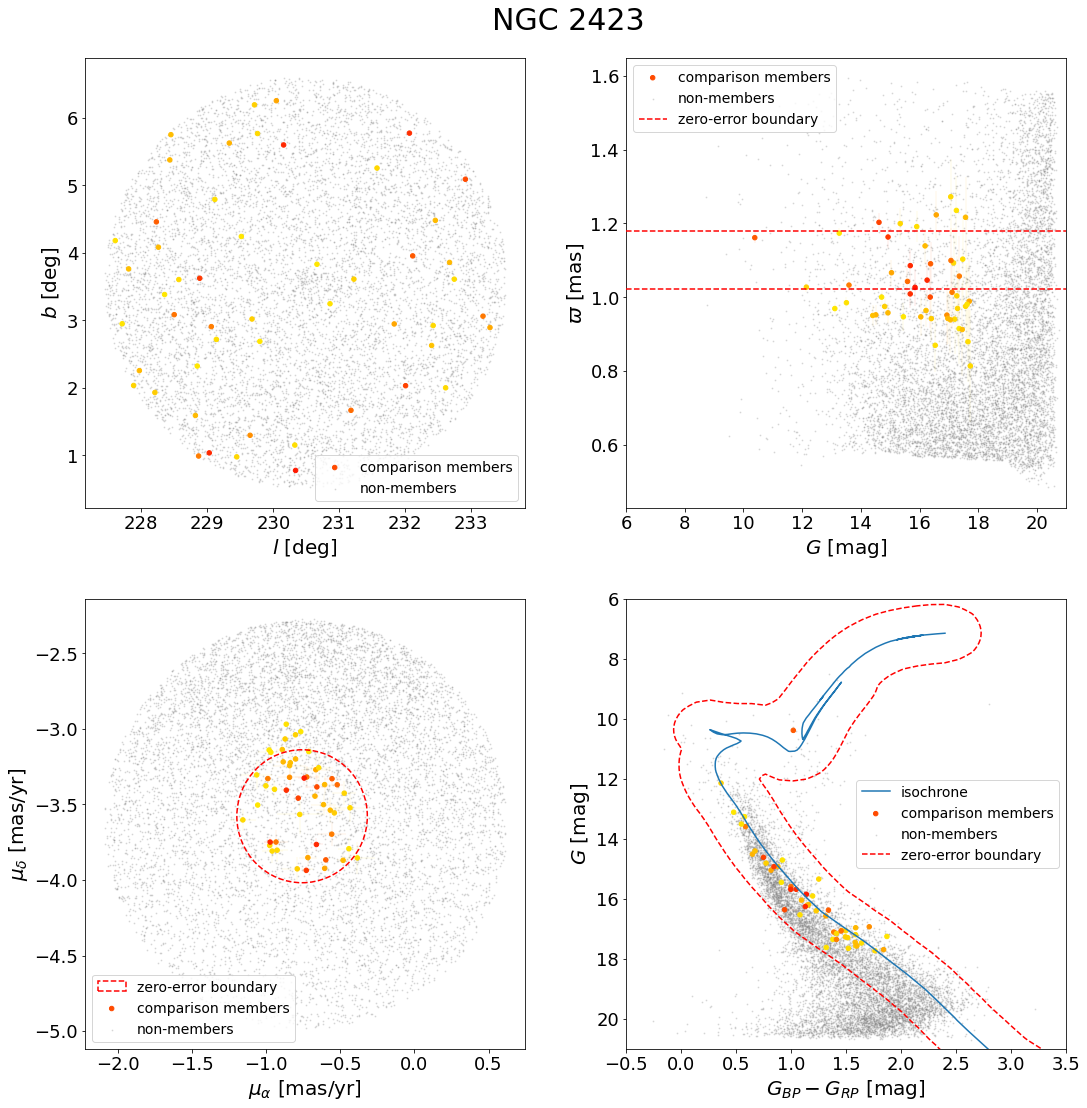

In [30]:
plot_sources(comparison_members, comparison=member_candidates, field_sources=non_member_candidates, 
             plot_type='unique_members', members_label=comparison_label, title=plot_title, 
             limits=limits, show_isochrone=True, show_boundaries=True, cluster=cluster)